In [148]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [149]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [150]:
# check what files in the pubmed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [151]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [152]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [153]:
 # Preprocess data
 # create a function to read lines of the document
def get_lines(filename):
  """

  Reads filename and return the lines of text as a list

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [154]:
# read in training files
train_lines  = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [155]:
len(train_lines)

210040

In [156]:
# How should the data look
def preprocess_text_with_line_numbers(filename):
  """

  Returns a list of dictionaries of abstractt line data

  Takes in filename, reads its contents and sorts through each line, 
  extrating things like target label, text of the sentence,
  and how many sentences are in the current abstract and what sentence number
  target line is.
  """

  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstact
  abstract_samples = [] # create an empty list of abstracts

  # Loop throught each line in target file
  for line in input_lines:
    if line.startswith('###'): #check to see if its an ID line
      abstract_id = line
      abstract_lines = " " # reset the abstract string if the line id an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split tatrget label form text
        line_data['target'] = target_text_split[0] # get target text and lower it
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number #  what number does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? 
        abstract_samples.append(line_data)

    else: # if the abvoe condition aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples   

In [157]:
# Get data from file and preprocess it

%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 1.48 s, sys: 206 ms, total: 1.68 s
Wall time: 1.74 s


In [158]:
# check the first abstract from the training data
train_samples[:20]

[{'line_number': 0,
  'target': ' OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures includ

In [159]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(24)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [160]:
# Distribution of labels
train_df['target'].replace({" OBJECTIVE": "OBJECTIVE", " BACKGROUND": "BACKGROUND", " METHODS": "METHODS", " CONCLUSIONS": "CONCLUSIONS"}, inplace=True)
val_df['target'].replace({" OBJECTIVE": "OBJECTIVE", " BACKGROUND": "BACKGROUND", " METHODS": "METHODS", " CONCLUSIONS": "CONCLUSIONS"}, inplace=True)
test_df['target'].replace({" OBJECTIVE": "OBJECTIVE", " BACKGROUND": "BACKGROUND", " METHODS": "METHODS", " CONCLUSIONS": "CONCLUSIONS"}, inplace=True)

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

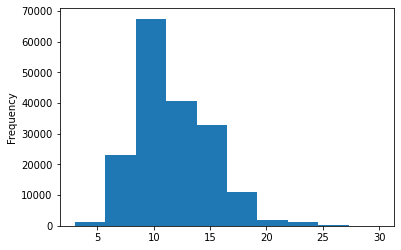

In [161]:
# Let's check the length of different lines

train_df.total_lines.plot.hist();

In [162]:
# convert abstract text lines into list
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [163]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [164]:
# Make numeric labels
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))


# check what it looks like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [165]:
# Extract labels and encode them into intergers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [166]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [167]:
## Model 0: Getting a baseline with Multinomial Naive Bayes

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ('tf-idf', TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [168]:
# Evaluate model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [169]:
# Make some prediction with the bsaeline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [170]:
from helper_functions import calculate_results

# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [171]:
## Preparing the text data for deep sequence model
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [172]:
# How long is the sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

In [173]:
max(sent_lens), min(sent_lens)

(296, 1)

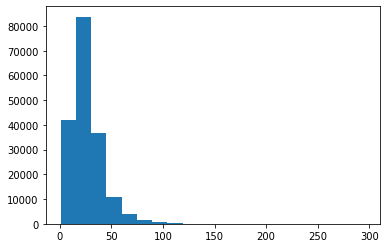

In [174]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [175]:
# How long of a sentence length covers 95% of the examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [176]:
# Create text vectorizer layer (turn word to numbers)
# How many word are in the vocabulary (68K for 20K dataset)
max_tokens = 68000

# Create a text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = 55) # desired output of length of vectorized sequences

In [177]:
# Adapt text vectorizer to the training sentences
text_vectorizer.adapt(train_sentences)

In [178]:
# Test out text vectorizer on random sentence

import random
target_sentence = random.choice(train_sentences)
print(f'Text: \n {target_sentence}')
print(f'\n Length of text: {len(target_sentence)}')
print(f'\n Vectorized text: {text_vectorizer([target_sentence])}')

Text: 
 no significant differences between fb and mb groups were found at any time point in the spatiotemporal parameters .

 Length of text: 115

 Vectorized text: [[   33    37   102    30  7366     3  5195    24     9   208    15   262
     63   294     5     2 11395   315     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [179]:
# How many words are in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocab: {len(rct_20k_text_vocab)}')
print(f'Most comoon words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in the vocab: 64841
Most comoon words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [180]:
# Create custom text embedding ( this captures the relationship between the vectrized words)

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocab
                               output_dim = 128, 
                               mask_zero = True, # to handle variable sequence lengths
                               name='token_embedding')


In [181]:
# show an example of embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding): \n {vectorized_sentence} \n')
embedding_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedding_sentence}\n')
print(f'Embedding entence shape: {embedding_sentence.shape}')

Sentence before vectorization:
 no significant differences between fb and mb groups were found at any time point in the spatiotemporal parameters .

Sentence after vectorization (before embedding): 
 [[   33    37   102    30  7366     3  5195    24     9   208    15   262
     63   294     5     2 11395   315     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]] 

Sentence after embedding:
 [[[ 0.04121157 -0.02899361 -0.03723945 ...  0.02580576  0.03857065
   -0.04123566]
  [-0.02375443 -0.02330039  0.02872108 ... -0.00955331  0.01951993
   -0.01491011]
  [ 0.00387652 -0.04914943  0.01125168 ...  0.03867035 -0.01639581
    0.02238486]
  ...
  [ 0.0250272   0.00249528 -0.03451445 ... -0.0213034   0.02914164
    0.00743688]
  [ 0.0250272   0.00249528 -0.03451445 ... -0.0213034   0.02914164
    0.00743688]
  [ 0.02

In [182]:
# Creating datasets (making the data load as fast aspossible)
# Turn data into tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [183]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [184]:
# Take tensorSliceDataset and turn them into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [185]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [186]:
# Model 2: Conv1D with token embeddings
# Create 1D conv model to process sequences

inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of out feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)


# Compile model
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [187]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 5)                 325 

In [188]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [189]:
len(train_dataset)

5627

In [190]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) 

Epoch 1/3
562/562 [==============================] - 64s 112ms/step - loss: 0.9129 - accuracy: 0.6408 - val_loss: 0.6816 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 61s 109ms/step - loss: 0.6525 - accuracy: 0.7606 - val_loss: 0.6305 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 62s 110ms/step - loss: 0.6127 - accuracy: 0.7755 - val_loss: 0.5960 - val_accuracy: 0.7856


In [191]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5955 - accuracy: 0.7871


[0.5954659581184387, 0.7871375679969788]

In [192]:
# Mak predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.5590374e-01, 1.3399348e-01, 6.3460596e-02, 3.2009509e-01,
         2.6547121e-02],
        [4.0267456e-01, 3.3605933e-01, 1.3542093e-02, 2.3713751e-01,
         1.0586563e-02],
        [1.6974583e-01, 6.7018154e-03, 1.7193344e-03, 8.2180947e-01,
         2.3526358e-05],
        ...,
        [9.8087539e-06, 7.7906763e-04, 6.9538766e-04, 6.3129573e-06,
         9.9850935e-01],
        [5.7817690e-02, 4.8213539e-01, 7.3401965e-02, 6.2037341e-02,
         3.2460758e-01],
        [1.6619208e-01, 6.9387043e-01, 4.1338287e-02, 5.0112054e-02,
         4.8487160e-02]], dtype=float32), (30212, 5))

In [193]:
# convert pred probs into classes

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [194]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [195]:
# calculate model 1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.71375612339467,
 'f1': 0.7848932098438711,
 'precision': 0.7841918101926298,
 'recall': 0.7871375612339467}

In [196]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [197]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
in this multicentre randomised controlled trial among art nave patients initiating first line art within the indian national programme , we found no significant effect of the mobile phone intervention on either time to virological failure or art adherence at the end of two years of therapy.trial registration current controlled trials isrctn@ .

Sentence after embedding:
[-0.04406899 -0.03226114  0.03981663 -0.05244441 -0.03841481  0.02306374
  0.04910124  0.04643236  0.0665996   0.02525212  0.06417601 -0.0396531
  0.06982581  0.01402856  0.06168258  0.00123853 -0.03910257  0.01633945
 -0.01756123 -0.02317474  0.03896268 -0.0014865  -0.04733522 -0.07316323
  0.03063166 -0.0501047  -0.0328961   0.04779449 -0.07776777  0.02948414] (truncated output)...

Length of sentence embedding:
512


In [198]:
# Building and fitting an NLP feature extraction model using 
# pretrained embeddings
# Define feature extraction model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) 
# tokenize text and create embedding of ache sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Can add more layers here if you want
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics =['accuracy'])

In [199]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [200]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data= valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9199 - accuracy: 0.6471 - val_loss: 0.7987 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7692 - accuracy: 0.7006 - val_loss: 0.7562 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7533 - accuracy: 0.7114 - val_loss: 0.7405 - val_accuracy: 0.7121


In [201]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7418 - accuracy: 0.7128


[0.741822361946106, 0.7128293514251709]

In [202]:
# Make predictions with thw feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.1677165e-01, 3.8117075e-01, 1.5067336e-03, 1.9261557e-01,
        7.9352688e-03],
       [3.3736530e-01, 4.9134767e-01, 2.8522562e-03, 1.6556370e-01,
        2.8710512e-03],
       [2.2992858e-01, 1.5040688e-01, 1.6029231e-02, 5.6431234e-01,
        3.9322961e-02],
       ...,
       [1.6392219e-03, 5.2052252e-03, 4.3054536e-02, 8.9210446e-04,
        9.4920892e-01],
       [3.5793809e-03, 4.3155856e-02, 2.1545649e-01, 1.4635850e-03,
        7.3634470e-01],
       [1.8537581e-01, 2.7095476e-01, 4.6964589e-01, 8.4124813e-03,
        6.5611102e-02]], dtype=float32)

In [203]:
# Convert the predictions probabiliteis 
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [204]:
# Calculate results from TF Hub pretrained embeedings results on val dataser
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.28293393353634,
 'f1': 0.7096511207715132,
 'precision': 0.7123517895245337,
 'recall': 0.7128293393353634}

In [205]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [206]:
# Model 3: Conv1D with character embeddings
# Create a character level tokenizer
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character level sequence into character
split_chars(random_training_sentence)

'i n   t h i s   m u l t i c e n t r e   r a n d o m i s e d   c o n t r o l l e d   t r i a l   a m o n g   a r t   n a v e   p a t i e n t s   i n i t i a t i n g   f i r s t   l i n e   a r t   w i t h i n   t h e   i n d i a n   n a t i o n a l   p r o g r a m m e   ,   w e   f o u n d   n o   s i g n i f i c a n t   e f f e c t   o f   t h e   m o b i l e   p h o n e   i n t e r v e n t i o n   o n   e i t h e r   t i m e   t o   v i r o l o g i c a l   f a i l u r e   o r   a r t   a d h e r e n c e   a t   t h e   e n d   o f   t w o   y e a r s   o f   t h e r a p y . t r i a l   r e g i s t r a t i o n   c u r r e n t   c o n t r o l l e d   t r i a l s   i s r c t n @   .'

In [207]:
# Split sequence level data into character level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [208]:
# Whats's the average character length?
char_lengths = [len(sentence) for sentence in train_sentences]
mean_char_length = np.mean(char_lengths)
mean_char_length

149.3662574983337

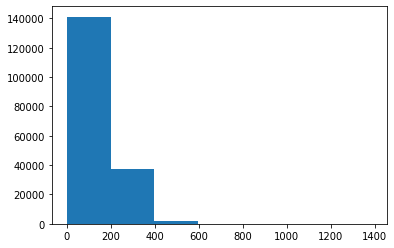

In [209]:
# Check the distribution of out sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lengths, bins=7);

In [210]:
# Find what characher length cover 95% of sequences
output_seq_char_len = int(np.percentile(char_lengths, 95))
output_seq_char_len

290

In [211]:
# Get all the keyboard characters
import string
alphabet = string.ascii_lowercase +string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [212]:
# create char level tokenizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab tokrn)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize=None,
                                    name='char_vectorizer')

In [213]:
# adapt char vectorizer to training character
char_vectorizer.adapt(train_chars)

In [214]:
# Check char vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different character in vocabulary: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least used characters: {char_vocab[-5:]}')

Number of different character in vocabulary: 57
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least used characters: ['|', '"', ']', '\\', '[']


In [215]:
# Test out char vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text: \n {random_train_chars}')
print(f'Lengthof random_train_chars: {len(random_train_chars)}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'Vectorized text: \n {vectorized_chars}')
print(f'Length of vectorized chars: {len(vectorized_chars[0])}')

Charified text: 
 t h e   m o s t   c o m m o n l y   r e p o r t e d   r e a s o n   f o r   d i s c o n t i n u a t i o n   w a s   a   s i d e   e f f e c t   (   @ / @   ,   @   %   )   .
Lengthof random_train_chars: 173
Vectorized text: 
 [[ 3 13  2 15  7  9  3 11  7 15 15  7  6 12 20  8  2 14  7  8  3  2 10  8
   2  5  9  7  6 17  7  8 10  4  9 11  7  6  3  4  6 16  5  3  4  7  6 21
   5  9  5  9  4 10  2  2 17 17  2 11  3 28 19 35 19 24 19 31 27 25  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0